In [348]:
import pandas as pd
import ast
import seaborn as sns
import requests
import matplotlib.pyplot as plt
import numpy as np


## Loading & Cleaning a half-done df
tldr: I cleaned an initially 42998 row df by removing any movies w/out a callable imdb_id (required to run the bechdel API), removing any languages with <500 films to them (there were 92 represented languages, many with just 1-2 films, which I doubt would appear on the bechdel test and would make it more difficult to incorporate language into a regression model), removing weirdly formatted release dates/movies before 1900, & removing registered runtimes <1hr (film standard) and >3hrs (outliers).
<br>
I then split this into dfs: the cleaned dataset as is (all) and one with only complete data on gender ratios for directing, production, & writing gender ratios (crew).
<br> That left me with ___10,373 movies in crew___ & ___28,395 in all___. Alas, this gets VERY paired down when running the Bechdel API...
<br>
<br>
_Aside: I was going to put in the entire cleaning process from my datahub, but the original zip file exceeds GitHub's limit, so I'm going to spare myself the extra couple minutes of adding in code that splits that original df into 2, zipping them up, loading them in here, and rerunning the original code_

In [194]:
movies = pd.read_csv('/Users/ashley/COGS209_Project/movies_pre_bechdel.csv')
print(movies.shape)
movies.head()

(32504, 28)


,id,imdb_id,runtime,release_date,original_language,Western,Romance,War,Crime,TV Movie,...,Adventure,Mystery,Drama,Family,Music,Comedy,avg_cast_gender,directing_avg_gender,production_avg_gender,writing_avg_gender
0,862,tt0114709,81.0,1995,en,0,0,0,0,0,...,0,0,0,1,0,1,1.750000,2.0,1.5,2.0
1,8844,tt0113497,104.0,1995,en,0,0,0,0,0,...,1,0,0,1,0,0,1.600000,2.0,2.0,2.0
2,15602,tt0113228,101.0,1995,en,0,1,0,0,0,...,0,0,0,0,0,1,1.571429,2.0,NaN,2.0
3,31357,tt0114885,127.0,1995,en,0,1,0,0,0,...,0,0,1,0,0,1,1.600000,2.0,1.5,NaN
4,11862,tt0113041,106.0,1995,en,0,0,0,0,0,...,0,0,0,0,0,1,1.545455,2.0,1.0,1.5


In [196]:
# Check for NAs
movies.isna().mean()


id                       0.000000
imdb_id                  0.000000
runtime                  0.000000
release_date             0.000000
original_language        0.000000
Western                  0.000000
Romance                  0.000000
War                      0.000000
Crime                    0.000000
TV Movie                 0.000000
Foreign                  0.000000
History                  0.000000
Thriller                 0.000000
Action                   0.000000
Horror                   0.000000
Fantasy                  0.000000
Animation                0.000000
Adventure                0.000000
Mystery                  0.000000
Drama                    0.000000
Family                   0.000000
Music                    0.000000
Comedy                   0.000000
avg_cast_gender          0.000000
directing_avg_gender     0.202806
production_avg_gender    0.490015
writing_avg_gender       0.303425
dtype: float64

In [195]:
# Remove any NAs from imdb ids (since these will be used to call movies later) & language
    # Will make a version cleaning NA crew data later!
movies = movies.dropna(subset = ['imdb_id', 'original_language', 'release_date'])
# Remove the random Western column that duplicated
movies = movies.drop(columns = ['Western.1'])
movies.shape
    # We still have 32499 movies to work with!

(32499, 27)

In [197]:
# Limit df to languages with >500 movies (will make it easier if we decide to turn this into binaries like genre)
languages = ['en', 'fr', 'it', 'ja', 'de', 'es']
movies = movies[movies['original_language'].isin(languages)]
# movies['original_language'].value_counts()

(28395, 27)
runtime
90.0     1647
100.0    1014
95.0      990
93.0      878
91.0      816
         ... 
176.0       9
171.0       7
159.0       7
164.0       6
179.0       6
Name: count, Length: 121, dtype: int64


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='runtime', ylabel='Count'>

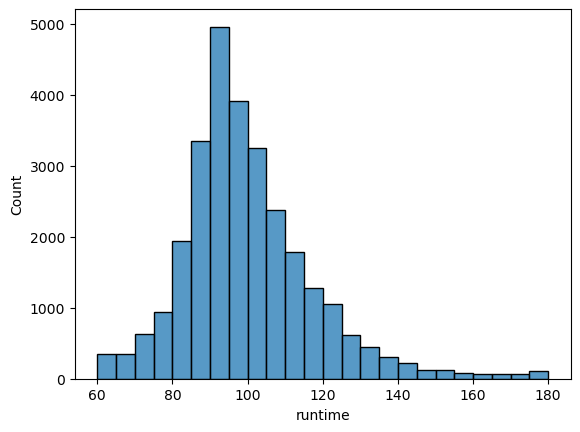

In [198]:
# Limit so movies are between 60-180 minutes (SGA guidelines for minimum + controlling for outliers in maximum)
## I cleaned for maximum before downloading this set
movies = movies[movies.runtime >= 60]
movies = movies[movies.runtime <=180]
print(movies.shape)
    # Still have 28395 movies left!
print(movies['runtime'].value_counts())
sns.histplot(movies['runtime'], binwidth = 5)
    # Right-skewed Gaussian representation with peak at 90-100mins

release_date
2014    958
2013    913
2015    903
2009    885
2011    854
       ... 
1917      7
1915      5
1914      4
1913      1
1912      1
Name: count, Length: 106, dtype: int64


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='release_date', ylabel='Count'>

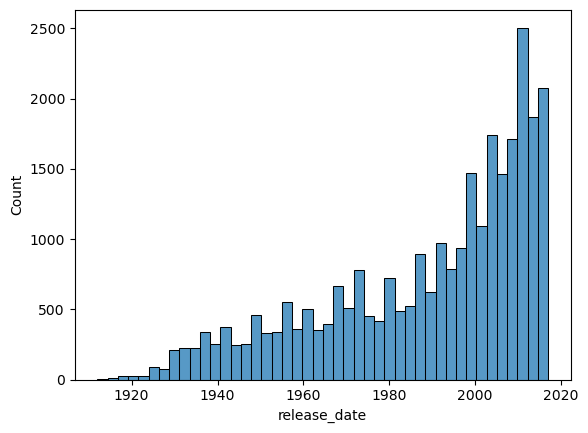

In [199]:
# Pre-cleaned so release date is between 1900-2017
print(movies['release_date'].value_counts())
sns.histplot(movies['release_date'])

In [200]:
# Basic Descriptive Stats
movies.describe()
    # For reference, gender is coded as 1=M, 2=F, 0=Child/Unknown
    # Any cast/crew values = 0 were filtered out in the initial cleaning process--so a movie with many kids and 2 adults will
        # still be present in this dataset, but the only the 2 adults' genders contribute to average_cast_gender
        # As seen here, avg gender is skewed towards women in every composition. >75% of movies have all-women writing/directing credits.

,id,runtime,release_date,Western,Romance,War,Crime,TV Movie,Foreign,History,...,Adventure,Mystery,Drama,Family,Music,Comedy,avg_cast_gender,directing_avg_gender,production_avg_gender,writing_avg_gender
count,28395.000000,28395.000000,28395.000000,28395.000000,28395.000000,28395.000000,28395.000000,28395.000000,28395.000000,28395.000000,...,28395.000000,28395.000000,28395.000000,28395.000000,28395.000000,28395.000000,28395.000000,23028.000000,15237.000000,20136.000000
mean,85282.903152,99.273569,1988.823701,0.030815,0.173059,0.031273,0.116323,0.020849,0.023138,0.030710,...,0.094629,0.068322,0.488044,0.067512,0.039267,0.319000,1.663403,1.912774,1.778853,1.897346
std,100092.324155,17.557472,24.201864,0.172820,0.378305,0.174058,0.320618,0.142880,0.150344,0.172533,...,0.292707,0.252302,0.499866,0.250911,0.194234,0.466097,0.211407,0.260279,0.307111,0.278533
min,5.000000,60.000000,1912.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,18190.500000,89.000000,1972.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.523810,2.000000,1.600000,2.000000
50%,43656.000000,96.000000,1997.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667,2.000000,2.000000,2.000000
75%,105762.500000,108.000000,2009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.800000,2.000000,2.000000,2.000000
max,467731.000000,180.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000


In [201]:
# Version of the movies dataset where NAs for director/production/writing average genders aren't NA
movies_crew = movies.dropna(subset = ['directing_avg_gender', 'production_avg_gender', 'writing_avg_gender'])
print(movies_crew.shape)
movies_crew.describe()
    # Only 10k to work with, but still theoretically plenty of data
    # Some minor shifts in means/stds, but no more than a few minutes/years or single percentage points in genre/gender composition

(10373, 27)


,id,runtime,release_date,Western,Romance,War,Crime,TV Movie,Foreign,History,...,Adventure,Mystery,Drama,Family,Music,Comedy,avg_cast_gender,directing_avg_gender,production_avg_gender,writing_avg_gender
count,10373.000000,10373.000000,10373.000000,10373.000000,10373.000000,10373.000000,10373.000000,10373.000000,10373.000000,10373.000000,...,10373.000000,10373.000000,10373.000000,10373.000000,10373.000000,10373.000000,10373.000000,10373.000000,10373.000000,10373.000000
mean,62200.212378,102.492914,1989.098139,0.032006,0.189048,0.033163,0.139400,0.011858,0.007616,0.033741,...,0.124361,0.079341,0.494071,0.071917,0.038658,0.328256,1.668591,1.900027,1.782791,1.905219
std,89319.021015,18.089535,23.650459,0.176025,0.391566,0.179071,0.346381,0.108251,0.086941,0.180572,...,0.330009,0.270283,0.499989,0.258364,0.192788,0.469601,0.183356,0.262384,0.292717,0.263693
min,5.000000,60.000000,1914.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,10339.000000,90.000000,1974.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.555556,2.000000,1.600000,2.000000
50%,26738.000000,99.000000,1997.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667,2.000000,2.000000,2.000000
75%,68735.000000,112.000000,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.800000,2.000000,2.000000,2.000000
max,460846.000000,180.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000


In [202]:
# Loading in movie titles bc we'll actually need those later
movies2 = pd.read_csv('/Users/ashley/COGS209_Project/movies_pre_bechdel_updated.csv')
movies2 = movies2[['id', 'title', 'original_title']]
movies = merged_df = pd.merge(movies, movies2, on=['id'], how='left')

movies_crew = merged_df = pd.merge(movies_crew, movies2, on=['id'], how='left')

print(movies.shape)
movies.head()

(28435, 29)


,id,imdb_id,runtime,release_date,original_language,Western,Romance,War,Crime,TV Movie,...,Drama,Family,Music,Comedy,avg_cast_gender,directing_avg_gender,production_avg_gender,writing_avg_gender,title,original_title
0,862,tt0114709,81.0,1995,en,0,0,0,0,0,...,0,1,0,1,1.750000,2.0,1.5,2.0,Toy Story,Toy Story
1,8844,tt0113497,104.0,1995,en,0,0,0,0,0,...,0,1,0,0,1.600000,2.0,2.0,2.0,Jumanji,Jumanji
2,15602,tt0113228,101.0,1995,en,0,1,0,0,0,...,0,0,0,1,1.571429,2.0,NaN,2.0,Grumpier Old Men,Grumpier Old Men
3,31357,tt0114885,127.0,1995,en,0,1,0,0,0,...,1,0,0,1,1.600000,2.0,1.5,NaN,Waiting to Exhale,Waiting to Exhale
4,11862,tt0113041,106.0,1995,en,0,0,0,0,0,...,0,0,0,1,1.545455,2.0,1.0,1.5,Father of the Bride Part II,Father of the Bride Part II


## Getting the Bechdel Test to Work
_aka learning how to read to the bottom of a website's option list and turn 4 days' worth of loading into 10 seconds_
</br>
tldr: tried calling the API on the df directly, like the project proposal said to do. Spent 4 days dying inside, getting code to work, & calling the API on the df. _Then_ found out you could load a df of the bechdel test results in 10 seconds and just merge based on matching ids. Died inside just a little more.
</br>
</br>
Final dfs:
</br>
__all data: 6981 rows__
</br>
__crew data: 4225 rows__

In [211]:
# # Define function for gathering bechdel test data
# def fetch_bechdel_data(imdb_id):
#     # Get API url
#     url = f"http://bechdeltest.com/api/v1/getMovieByImdbId?imdbid={imdb_id}"
#     # Request info for imdb_id, + fail-safe
#     try:
#         response = requests.get(url)
#         response.raise_for_status()
#         return response.json()
#     except requests.RequestException as e:
#         print(f"Error fetching {imdb_id}: {e}")
#         return None

In [212]:
# # Creating subset of code to make sure this works
# bech = movies_crew[['imdb_id']]
# # Get rid of tt before imdb id numbers for calling fn
# bech.loc[:, 'imdb_id'] = bech['imdb_id'].str.replace('tt', '', regex=False)
# # Sanity check
# bech.shape
# # Create subset for beta testing
# df = bech.iloc[5001:10000].copy()
# df.shape

In [213]:
# # Call the function on the data
# for idx, imdb_id in enumerate(df['imdb_id']):
#     df.loc[:, 'bechdel_data'] = df['imdb_id'].apply(lambda x: fetch_bechdel_data(x))
#     sleep(0.5)  # wait 0.5s between calls

# # Save progress every 500 rows
#     if idx % 20 == 0:
#         df.to_csv('bechdel_progress.csv', index=False)
#         print(f"Checkpoint saved at row {idx}")

# print(df.head())

In [214]:
# # Call the function on the data
# for idx, imdb_id in enumerate(df['imdb_id']):
#     df.loc[:, 'bechdel_data'] = df['imdb_id'].apply(lambda x: fetch_bechdel_data(x))
#     sleep(0.5)  # wait 0.5s between calls

# # Save progress every 5 rows
#     if idx % 5 == 0:
#         df.to_csv('bechdel_progress.csv', index=False)
#         print(f"Checkpoint saved at row {idx}")

# print(df.head())

In [215]:
# # Call the function on the data
# for idx, imdb_id in enumerate(df['imdb_id']):
#     df.loc[:, 'bechdel_data'] = df['imdb_id'].apply(lambda x: fetch_bechdel_data(x))
#     sleep(0.5)  # wait 0.5s between calls

# # Save progress every 2 rows
#     if idx % 2 == 0:
#         df.to_csv('bechdel_progress2.csv', index=False)
#         print(f"Checkpoint saved at row {idx}")

# print(df.head())

In [216]:
# df = df.reset_index(drop=True)
# print(df.shape)
# df.head()

In [217]:
# # Call the function on the data
# for idx, imdb_id in enumerate(df['imdb_id']):
#     df.loc[:, 'bechdel_data'] = df['imdb_id'].apply(lambda x: fetch_bechdel_data(x))
#     sleep(0.5)  # wait 0.5s between calls

# # Save progress every 2 rows
#     if idx % 2 == 0:
#         df.to_csv('bechdel_progress3.csv', index=False)
#         print(f"Checkpoint saved at row {idx}")

# print(df.head())

In [218]:
# bechdel_1 = pd.read_csv('/Users/ashley/COGS209_Project/bechdel_progress.csv')
# bechdel_2 = pd.read_csv('/Users/ashley/COGS209_Project/bechdel_progress2.csv')
# bechdel_3 = pd.read_csv('/Users/ashley/COGS209_Project/bechdel_progress3.csv')

# print(bechdel_1.shape)
# print(bechdel_2.shape)
# print(bechdel_3.shape)

In [219]:
# bechdel = pd.concat([bechdel_1, bechdel_2, bechdel_3], ignore_index=True)
# print(bechdel.shape)
# bechdel.head()

In [220]:
# bechdel['bechdel_data'] = bechdel['bechdel_data'].apply(ast.literal_eval)
# # Turn bechdel_data into df
# bechdel_info = pd.json_normalize(bechdel['bechdel_data'])
# # Turn each list item into row
# bechdel_test = pd.concat([bechdel.drop(columns='bechdel_data'), bechdel_info], axis=1)
# bechdel_test.head()

In [221]:
# bechdel_success = bechdel_test[bechdel_test['status'].isna()]
# print(bechdel_success.shape)
# bechdel_success.head()

In [222]:
# bechdel_fail = bechdel_test[bechdel_test['status']=='404']
# bechdel_fail.shape

In [223]:
# bech = movies[['imdb_id']].copy()
# # Get rid of tt before imdb id numbers for calling fn
# bech.loc[:, 'imdb_id'] = bech['imdb_id'].str.replace('tt', '', regex=False)
# # Turn into string so I can remove already called rows
# bech['imdb_id'] = bech['imdb_id'].astype(int)
# # Sanity check
# print(bech.shape)

# df = bech[~bech['imdb_id'].isin(bechdel['imdb_id'])].copy()
# # Create subset for faster loading
# df = bech.iloc[15001:18346].copy()
# df.shape

In [224]:
# # Reset index
# df = df.reset_index(drop=True)

# # Call the function on the data
# for idx, imdb_id in enumerate(df['imdb_id']):
#     df.loc[:, 'bechdel_data'] = df['imdb_id'].apply(lambda x: fetch_bechdel_data(x))
#     sleep(0.5)  # wait 0.5s between calls

# # Save progress every 2 rows
#     if idx % 2 == 0:
#         df.to_csv('nocrew3_bechdel_progress.csv', index=False)
#         print(f"Checkpoint saved at row {idx}")

# print(df.head())

In [225]:
# ## .........The Faster Way
# url = "http://bechdeltest.com/api/v1/getAllMovies"

# # Make the request
# response = requests.get(url)

# # Check for success
# if response.status_code == 200:
#     movies_test = response.json()  # This is a list of dicts
#     print(f"Fetched {len(movies_test)} movies")
    
#     # Turn into a DataFrame
#     df_movies = pd.DataFrame(movies_test)
#     print(df_movies.head())
# else:
#     print(f"Error: {response.status_code}")

In [226]:
## Match by imdb_id
# Turn imdb_id into str value & remove tt from movies dfs
movies_crew_test = movies_crew.copy()
movies_crew_test['imdb_id'] = movies_crew_test['imdb_id'].astype(str)
movies_crew_test['title'] = movies_crew_test['title'].astype(str)
movies_crew_test.loc[:, 'imdb_id'] = movies_crew_test.loc[:, 'imdb_id'] = movies_crew_test['imdb_id'].str.replace('tt', '', regex=False)

movies_all_test = movies.copy()
movies_all_test['imdb_id'] = movies_all_test['imdb_id'].astype(str)
movies_all_test['title'] = movies_all_test['title'].astype(str)
movies_all_test.loc[:, 'imdb_id'] = movies_all_test.loc[:, 'imdb_id'] = movies_all_test['imdb_id'].str.replace('tt', '', regex=False)

# df_movies['imdbid'] = df_movies['imdbid'].astype(str)

# Make imdbid match imdb_id
# df_movies = df_movies.rename(columns={'imdbid': 'imdb_id'})

## Join movies dfs to df_movies so that only matching imdb ids get through
movies_crew_id = pd.merge(df_movies, movies_crew_test, on='imdb_id', how='inner')
movies_all_id = pd.merge(df_movies, movies_all_test, on='imdb_id', how='inner')

movies_crew_name = pd.merge(df_movies, movies_crew_test, on='title', how='inner')
movies_all_name = pd.merge(df_movies, movies_all_test, on='title', how='inner')

# Sanity Check
print(movies_all_id.shape)
print(movies_crew_id.shape)
print(movies_all_name.shape)
print(movies_crew_name.shape)
    # Going with IMDB id for better join rate


(6981, 33)
(4225, 33)
(5702, 33)
(3322, 33)


In [227]:
# Removing duplicates
movies_all = movies_all_id.drop(columns = ['title_y', 'id_y'])
movies_cast = movies_crew_id.drop(columns = ['title_y', 'id_y'])

movies_all = movies_all.rename(columns={'title_x': 'title'})
movies_all = movies_all.rename(columns={'id_x': 'id'})
movies_cast = movies_cast.rename(columns={'title_x': 'title'})
movies_cast = movies_cast.rename(columns={'id_x': 'id'})

# sanity check
print(movies_all.shape)
movies_cast.shape

(6981, 31)


(4225, 31)

In [272]:
## Saving these just in case
movies_all.to_csv('all_bechdel_results.csv', index=False)
movies_cast.to_csv('cast_bechdel_results.csv', index=False)

In [228]:
# ## Loading & combining dfs
# # For Available Crew Data
# bechdel_1 = pd.read_csv('/Users/ashley/COGS209_Project/bechdel_progress.csv')
# bechdel_2 = pd.read_csv('/Users/ashley/COGS209_Project/bechdel_progress2.csv')
# bechdel_3 = pd.read_csv('/Users/ashley/COGS209_Project/bechdel_progress3.csv')

# print(bechdel_1.shape)
# print(bechdel_2.shape)
# print(bechdel_3.shape)

# # For Unavailable Crew Data
# bechdel_4 = pd.read_csv('/Users/ashley/COGS209_Project/nocrew_bechdel_progress.csv')
# bechdel_5 = pd.read_csv('/Users/ashley/COGS209_Project/nocrew2_bechdel_progress.csv')
# bechdel_6 = pd.read_csv('/Users/ashley/COGS209_Project/nocrew3_bechdel_progress.csv')

# print(bechdel_4.shape)
# print(bechdel_5.shape)
# print(bechdel_6.shape)

# # Combined dfs
# bechdel_crew = pd.concat([bechdel_1, bechdel_2, bechdel_3], ignore_index=True)
# bechdel_all = pd.concat([bechdel_crew, bechdel_4, bechdel_5, bechdel_6], ignore_index=True)

# print(bechdel_crew.shape)
# print(bechdel_all.shape)

In [229]:
# ## Expanding bechdel col
# bechdel_crew['bechdel_data'] = bechdel_crew['bechdel_data'].apply(ast.literal_eval)
# bechdel_all['bechdel_data'] = bechdel_all['bechdel_data'].apply(ast.literal_eval)

# # Turn bechdel_data into df
# bechdel_info = pd.json_normalize(bechdel_crew['bechdel_data'])
# bechdel_info2 = pd.json_normalize(bechdel_all['bechdel_data'])

# # Turn each list item into row
# bechdel_crew = pd.concat([bechdel_crew.drop(columns='bechdel_data'), bechdel_info], axis=1)
# bechdel_all = pd.concat([bechdel_all.drop(columns='bechdel_data'), bechdel_info2], axis=1)

# # Sanity Check
# print(bechdel_crew.shape)
# print(bechdel_all.shape)
# bechdel_crew.head()

In [230]:
# ## Removing NAs & Unneeded Columns
# bechdel_crew_success = bechdel_crew[bechdel_crew['status'].isna()]
# bechdel_all_success = bechdel_all[bechdel_all['status'].isna()]

# drop = ['imdbid', 'status', 'version', 'description', 'date', 'year', 'submitterid', 'id']
# bechdel_crew_success = bechdel_crew_success.drop(columns = drop)
# bechdel_all_success = bechdel_all_success.drop(columns = drop)


# # Sanity Checks
# print(bechdel_crew_success.shape)
# print(bechdel_all_success.shape)
# bechdel_crew_success.head()

In [231]:
# ## Load in version of movies df with original titles and match that way

# # Match by title
# bechdel_crew = pd.merge(bechdel_crew_success, movies2, on = 'title', how = 'inner')
# bechdel_all = pd.merge(bechdel_all_success, movies2, on = 'title', how = 'inner')

# # Remove Unneeded cols for easier viewing going forward
# remove = ['Western.1', 'imdb_id_x', 'imdb_id_y', 'id']
# bechdel_crew = bechdel_crew.drop(columns = remove)
# bechdel_all = bechdel_all.drop(columns = remove)


# # Sanity check
# print('Sanity Check 1')
# print(bechdel_crew.shape)
# print(bechdel_all.shape)
# bechdel_crew.head()
#     # Where the missing ~1k movies are is beyond me--I tried combining dfs sorted on original titles, imdb ids, etc. 
#     # and this is the best I got. I could rerun the API on a df before I isolated the imdb ids, but that would take another day of loading
#     # so I'm going to call it here...

## FINALLY...EDA (by crew v full dataset)
_tldr: both datasets are pretty close in makeup between the crew & full datasets._
</br>
Movies are largely 90-115mins long
</br>
Released between 1984-2011 (25% fall between ~1915-1983, 25% movies between 2011-2017)
</br>
English is overwhelmingly reprented (~92%)
</br>
~1/2 the movies are a drama, ~1/3 comedy, ~1/4 thriller, ~1/5 romance, ~1/10 crime, ~1/10 horror, ~1/10 fantasy, ~1/10 family, ~1/10 mystery
</br>
Directing/Writing are predominantly women (>75% are fully women), cast ratios are female-leaning (Quart1-3: .55-.79), production also female-leaning (Quart1-3: 0.5-1)
</br>
A little over half pass the bechdel test

In [ ]:
## Very Basic Breakdowns between All & Crew Data--loading initial graphs for both so I don't have to rerun these later :P
# Starting w/ colnames (same for both dfs)
print(movies_cast.columns)
# movies_all.columns

Index(['year', 'title', 'imdb_id', 'id', 'rating', 'runtime', 'release_date',
       'original_language', 'Western', 'Romance', 'War', 'Crime', 'TV Movie',
       'Foreign', 'History', 'Thriller', 'Action', 'Horror', 'Fantasy',
       'Animation', 'Adventure', 'Mystery', 'Drama', 'Family', 'Music',
       'Comedy', 'avg_cast_gender', 'directing_avg_gender',
       'production_avg_gender', 'writing_avg_gender', 'original_title'],
      dtype='object')


In [255]:
movies_cast['runtime'] = movies_cast['runtime'].astype(int)
movies_all['runtime'] = movies_all['runtime'].astype(int)

Crew Only
count    4225.000000
mean      107.424379
std        18.858588
min        60.000000
25%        94.000000
50%       104.000000
75%       118.000000
max       180.000000
Name: runtime, dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Movie Runtime Distribution (minutes)')

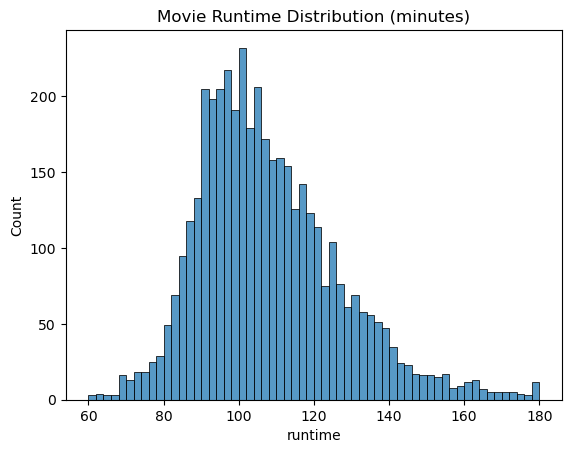

In [324]:
print('Crew Only')
print(movies_cast['runtime'].describe())
cast_runtime = sns.histplot(movies_cast['runtime'], bins = 60)
cast_runtime.set_title('Movie Runtime Distribution (minutes)')

Full Data Set
count    6981.000000
mean      104.899441
std        18.301743
min        60.000000
25%        92.000000
50%       102.000000
75%       115.000000
max       180.000000
Name: runtime, dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Movie Runtime Distribution (minutes)')

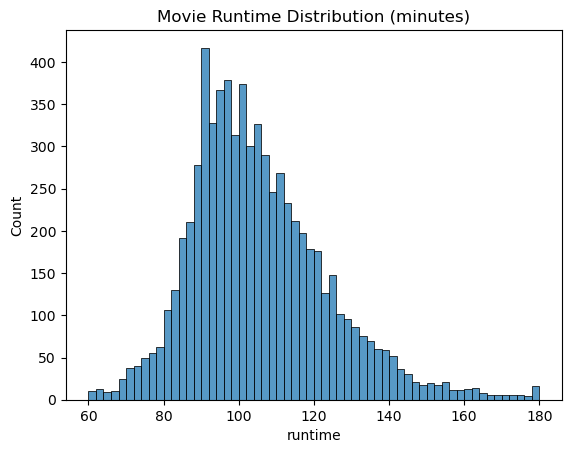

In [325]:
print('Full Data Set')
print(movies_all['runtime'].describe())
all_runtime = sns.histplot(movies_all['runtime'], bins = 60)
all_runtime.set_title('Movie Runtime Distribution (minutes)')

Crew Data Set
count    4225.000000
mean     1994.863195
std        20.820986
min      1919.000000
25%      1987.000000
50%      2002.000000
75%      2010.000000
max      2017.000000
Name: year, dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Year Movie Released')

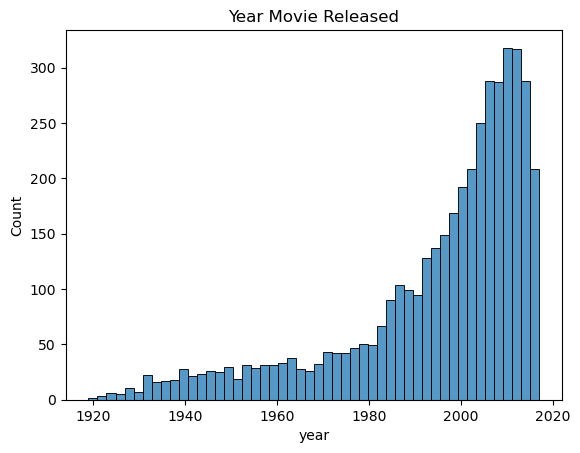

In [ ]:
## Year Released
print('Crew Data Set')
print(movies_cast['year'].describe())
cast_year = sns.histplot(movies_cast['year'], bins = 50)
cast_year.set_title('Year Movie Released')
    # Movies released between 1912 & 2017, left skewed graph

Full Data Set
count    6981.000000
mean     1994.028219
std        22.037151
min      1912.000000
25%      1984.000000
50%      2002.000000
75%      2011.000000
max      2017.000000
Name: year, dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Year Movie Released')

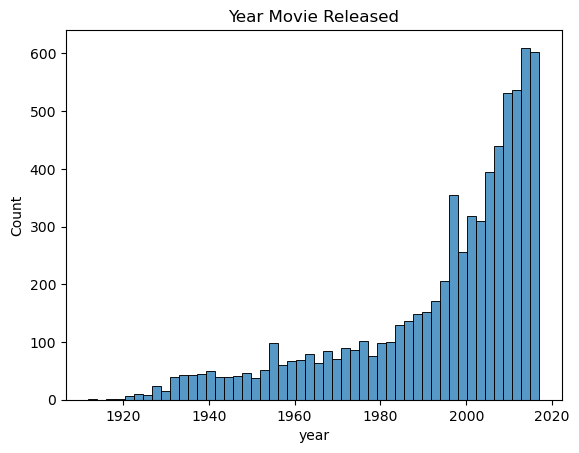

In [327]:
print('Full Data Set')
print(movies_all['year'].describe())
all_year = sns.histplot(movies_all['year'], bins = 50)
all_year.set_title('Year Movie Released')

Crew Data Set
original_language
en    3900
fr     144
de      58
ja      51
es      44
it      28
Name: count, dtype: int64


Text(0.5, 0, 'Original Language')

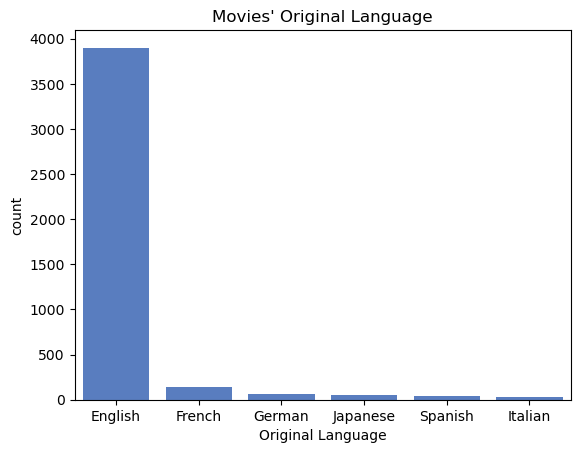

In [270]:
# Crew Language
    # Overwhelmingly English...not surprised
print('Crew Data Set')
print(movies_cast['original_language'].value_counts())
cast_language = sns.barplot(x=movies_cast['original_language'].value_counts().index, y=movies_cast['original_language'].value_counts(), 
                            color = sns.color_palette("muted")[0])
lang_labels = ['English', 'French', 'German', 'Japanese', 'Spanish', 'Italian']
cast_language.set_title("Movies' Original Language")
cast_language.set_xticklabels(lang_labels)
cast_language.set_xlabel('Original Language')

Full Data Set
original_language
en    6110
fr     344
ja     204
es     113
de     108
it     102
Name: count, dtype: int64


Text(0.5, 0, 'Original Language')

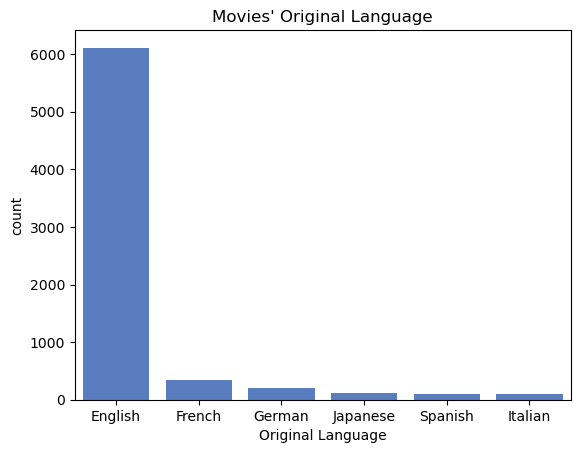

In [271]:
# All Language
print('Full Data Set')
print(movies_all['original_language'].value_counts())
all_language = sns.barplot(x=movies_all['original_language'].value_counts().index, y=movies_all['original_language'].value_counts(), 
                            color = sns.color_palette("muted")[0])
lang_labels = ['English', 'French', 'German', 'Japanese', 'Spanish', 'Italian']
all_language.set_title("Movies' Original Language")
all_language.set_xticklabels(lang_labels)
all_language.set_xlabel('Original Language')

Crew Genre Counts
Western        84
Romance       820
War           125
Crime         586
TV Movie       18
Foreign         7
History       161
Thriller     1127
Action        922
Horror        560
Fantasy       416
Animation     225
Adventure     731
Mystery       357
Drama        2082
Family        408
Music         177
Comedy       1500
dtype: int64


Text(0.5, 0, 'count')

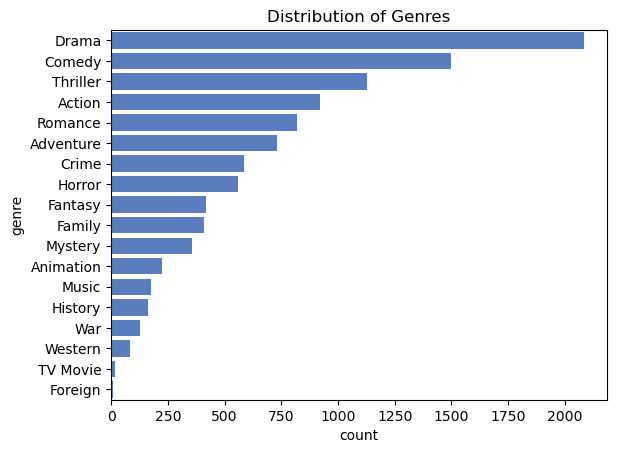

In [429]:
# Crew Genre Counts
    # If we're including original language, we might want to omit foreign films as a predictor...
print('Crew Genre Counts')
genres = ['Western', 'Romance', 'War', 'Crime', 'TV Movie', 'Foreign', 'History', 'Thriller', 'Action', 'Horror', 'Fantasy',
       'Animation', 'Adventure', 'Mystery', 'Drama', 'Family', 'Music', 'Comedy']
print((movies_cast[genres] == 1).sum())

counts = (movies_cast[genres] == 1).sum().reset_index()
counts.columns = ['column', 'count']
counts = counts.sort_values('count', ascending=False)

cast_genres = sns.barplot(data=counts, x='count', y='column', color = sns.color_palette("muted")[0])
plt.title('Distribution of Genres')
# plt.xticks(rotation=90)
plt.ylabel('genre')
plt.xlabel('count')

Full Genre Counts
Western       141
Romance      1370
War           197
Crime         868
TV Movie       67
Foreign        47
History       251
Thriller     1675
Action       1335
Horror        890
Fantasy       626
Animation     428
Adventure    1026
Mystery       547
Drama        3586
Family        684
Music         330
Comedy       2505
dtype: int64


Text(0.5, 0, 'count')

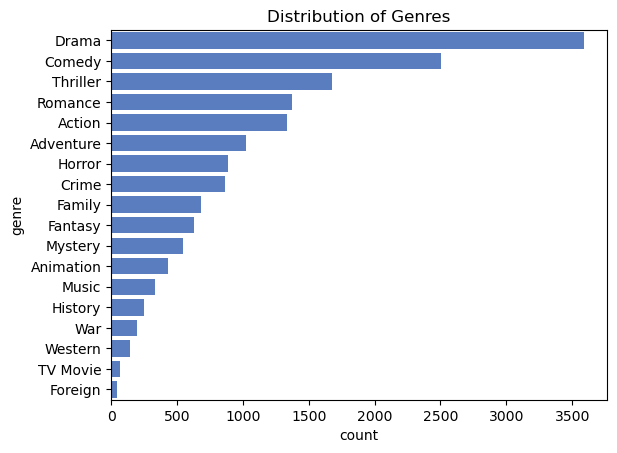

In [427]:
# All Genre Counts
print('Full Genre Counts')
print((movies_all[genres] == 1).sum())

counts = (movies_all[genres] == 1).sum().reset_index()
counts.columns = ['column', 'count']
counts = counts.sort_values('count', ascending=False)

all_genres = sns.barplot(data=counts, x='count', y='column', color = sns.color_palette("muted")[0])
plt.title('Distribution of Genres')
# plt.xticks(rotation=90)
plt.ylabel('genre')
plt.xlabel('count')

In [318]:
gender_splits = ['avg_cast_gender', 'directing_avg_gender', 'production_avg_gender', 'writing_avg_gender']
# Make Gender splits more intuitive (0=all M, 1=all F)
movies_cast[gender_splits] = movies_cast[gender_splits] - 1
movies_all[gender_splits] = movies_all[gender_splits] - 1

Crew Gender Split Counts
       avg_cast_gender  directing_avg_gender  production_avg_gender  \
count      4225.000000           4225.000000            4225.000000   
mean          0.655903              0.868963               0.735818   
std           0.180115              0.289005               0.277960   
min           0.000000              0.000000               0.000000   
25%           0.545455              1.000000               0.500000   
50%           0.666667              1.000000               0.750000   
75%           0.785714              1.000000               1.000000   
max           1.000000              1.000000               1.000000   

       writing_avg_gender  
count         4225.000000  
mean             0.885841  
std              0.284717  
min              0.000000  
25%              1.000000  
50%              1.000000  
75%              1.000000  
max              1.000000  


Text(0.5, 0, 'department')

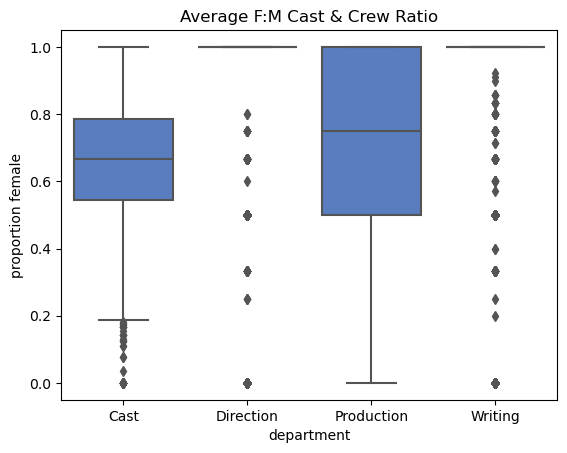

In [ ]:
## Crew Analysis
# Pretty female-heavy in all but the cast department (a little female-heavy, but more of an even split)
print('Crew Gender Split Counts')
print(movies_cast[gender_splits].describe())
cast_genders = sns.boxplot(data = movies_cast[gender_splits], color = sns.color_palette("muted")[0])
department_labels = ['Cast', 'Direction', 'Production', 'Writing']

cast_genders.set_xticklabels(department_labels)
plt.title('Average F:M Cast & Crew Ratio')
plt.ylabel('proportion female')
plt.xlabel('department')



Full Gender Split Counts
       avg_cast_gender  directing_avg_gender  production_avg_gender  \
count      6981.000000           5967.000000            5366.000000   
mean          0.639502              0.864383               0.734687   
std           0.197903              0.305364               0.287191   
min           0.000000              0.000000               0.000000   
25%           0.500000              1.000000               0.500000   
50%           0.666667              1.000000               0.777778   
75%           0.777778              1.000000               1.000000   
max           1.000000              1.000000               1.000000   

       writing_avg_gender  
count         5788.000000  
mean             0.869675  
std              0.305790  
min              0.000000  
25%              1.000000  
50%              1.000000  
75%              1.000000  
max              1.000000  
NA Count
avg_cast_gender             0
directing_avg_gender     1014
production_avg

Text(0.5, 0, 'department')

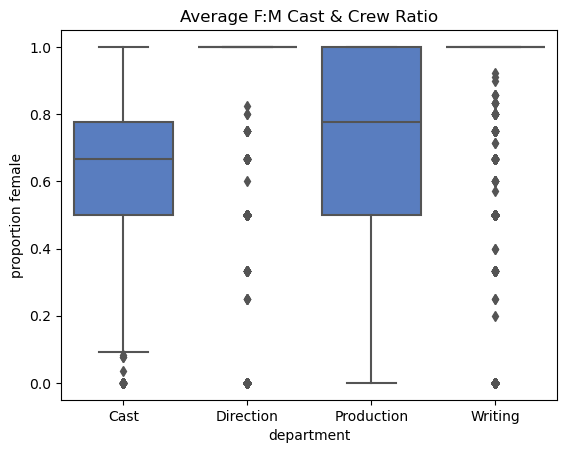

In [ ]:
# All Analysis
print('Full Gender Split Counts')
print(movies_all[gender_splits].describe())
print('NA Count')
print(movies_all[gender_splits].isna().sum())
all_genders = sns.boxplot(data = movies_all[gender_splits], color = sns.color_palette("muted")[0])
department_labels = ['Cast', 'Direction', 'Production', 'Writing']

all_genders.set_xticklabels(department_labels)
plt.title('Average F:M Cast & Crew Ratio')
plt.ylabel('proportion female')
plt.xlabel('department')

Crew Bechdel Rating Data
0: no two women, 1: no talking, 2: talking about a man, 3: it passes the test
rating
3    2249
1    1062
2     515
0     399
Name: count, dtype: int64


(array([0, 1, 2, 3]),
 [Text(0, 0, '0: <2 women'),
  Text(1, 0, '1: no talking'),
  Text(2, 0, '2: talking about a man'),
  Text(3, 0, '3: passes')])

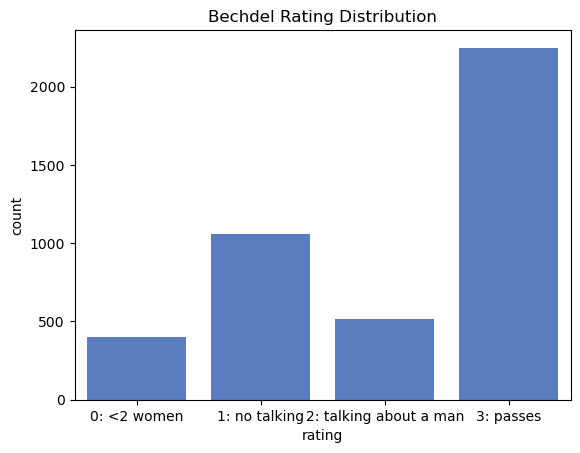

In [346]:
# Crew Rating Counts
print('Crew Bechdel Rating Data')
print('0: no two women, 1: no talking, 2: talking about a man, 3: it passes the test')
print(movies_cast['rating'].value_counts())
crew_test = sns.barplot(x=movies_cast['rating'].value_counts().index, y=movies_cast['rating'].value_counts(), 
                            color = sns.color_palette("muted")[0])
crew_test.set_title("Bechdel Rating Distribution")
test_labels = ['0: <2 women', '1: no talking', '2: talking about a man', '3: passes']
crew_test.set_xticklabels(test_labels)
crew_test.set_xlabel('rating')
plt.xticks(rotation=0)


Full Bechdel Rating Data
0: no two women, 1: no talking, 2: talking about a man, 3: it passes the test
rating
3    3878
1    1645
2     783
0     675
Name: count, dtype: int64


(array([0, 1, 2, 3]),
 [Text(0, 0, '0: <2 women'),
  Text(1, 0, '1: no talking'),
  Text(2, 0, '2: talking about a man'),
  Text(3, 0, '3: passes')])

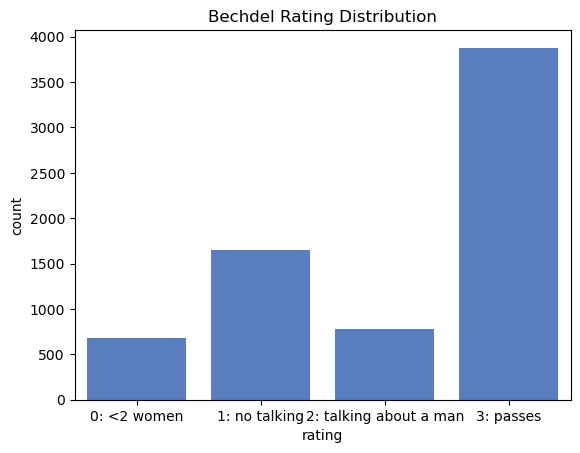

In [345]:
# All Rating Counts
print('Full Bechdel Rating Data')
print('0: no two women, 1: no talking, 2: talking about a man, 3: it passes the test')
print(movies_all['rating'].value_counts())
crew_test = sns.barplot(x=movies_all['rating'].value_counts().index, y=movies_all['rating'].value_counts(), 
                            color = sns.color_palette("muted")[0])
crew_test.set_title("Bechdel Rating Distribution")
crew_test.set_xticklabels(test_labels)
crew_test.set_xlabel('rating')
plt.xticks(rotation=0)


## EDA: By Bechdel Rating (Binary Outcome)
To simplify, I only loaded by the crew_only df since results were about the same, but this can easily be changed!
</br>
not much of a difference found by runtime, maybe something to be found in release year (but hard to say), & languages are too skewed.
</br>
Genre could be a little helpful--it does seem like there's differences in makeup by whether it passes.
</br>
In every metric, the female gender ratio is HIGHER in all departments when FAILING the Bechdel Test

In [357]:
## Create col turning rating into categorical var for coloring
movies_cast['passes_test'] = np.where(movies_cast['rating'] == 3, "Passes", "Fails")
# Sanity Check
movies_cast['passes_test'].value_counts()

passes_test
Passes    2249
Fails     1976
Name: count, dtype: int64

Passes Stats
count    2249.000000
mean      106.557137
std        18.034601
min        61.000000
25%        94.000000
50%       104.000000
75%       117.000000
max       180.000000
Name: runtime, dtype: float64
Fails Stats
count    1976.000000
mean      108.411437
std        19.712856
min        60.000000
25%        94.000000
50%       105.500000
75%       119.000000
max       180.000000
Name: runtime, dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a len

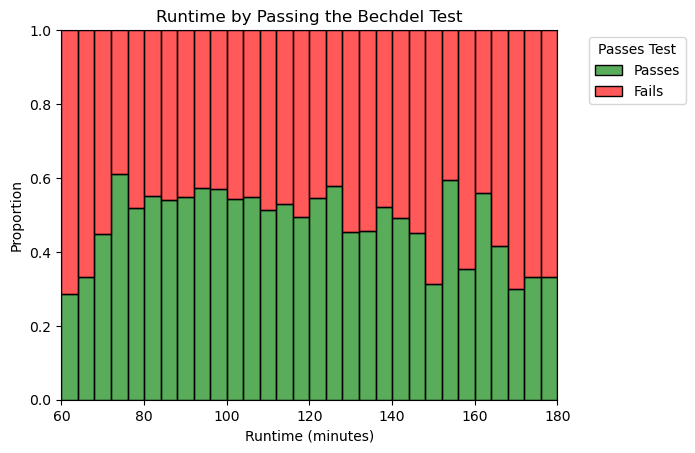

In [ ]:
## Runtime--this graph makes it look like something's here, but if you look at the stats it's unlikely
print('Passes Stats')
print(movies_cast[movies_cast['passes_test'] == 'Passes']['runtime'].describe())
print('Fails Stats')
print(movies_cast[movies_cast['passes_test'] == 'Fails']['runtime'].describe())

runtime_pass = sns.histplot(data=movies_cast, x='runtime', bins = 30, hue='passes_test', multiple='fill', edgecolor='black', 
                            alpha = 0.65, palette={'Passes': 'g', 'Fails': 'r'})
plt.ylabel('Proportion')
plt.xlabel('Runtime (minutes)')
plt.title('Runtime by Passing the Bechdel Test')
plt.legend(title='Passes Test', labels=['Passes', 'Fails'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Passes Stats
count    2249.000000
mean     1996.843931
std        19.695211
min      1921.000000
25%      1990.000000
50%      2004.000000
75%      2011.000000
max      2017.000000
Name: year, dtype: float64
Fails Stats
count    1976.000000
mean     1992.608806
std        21.819659
min      1919.000000
25%      1983.000000
50%      2000.000000
75%      2009.000000
max      2017.000000
Name: year, dtype: float64


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a len

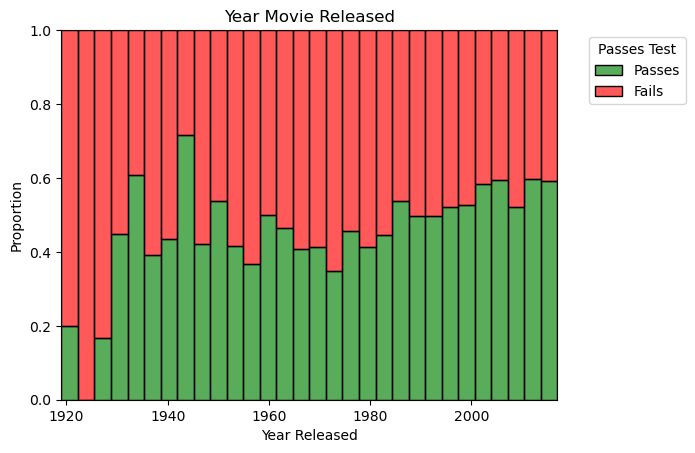

In [ ]:
## Year Released (tried this way taking inspo from the first group)
print('Passes Stats')
print(movies_cast[movies_cast['passes_test'] == 'Passes']['year'].describe())
print('Fails Stats')
print(movies_cast[movies_cast['passes_test'] == 'Fails']['year'].describe())

runtime_pass = sns.histplot(data=movies_cast, x='year', bins = 30, hue='passes_test', multiple='fill', edgecolor='black', 
                            alpha = 0.65, palette={'Passes': 'g', 'Fails': 'r'})
plt.ylabel('Proportion')
plt.xlabel('Year Released')
plt.title('Year Movie Released')
plt.legend(title='Passes Test', labels=['Passes', 'Fails'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Text(0.5, 1.0, 'Year Movie Released, by Passing Bechdel Test')

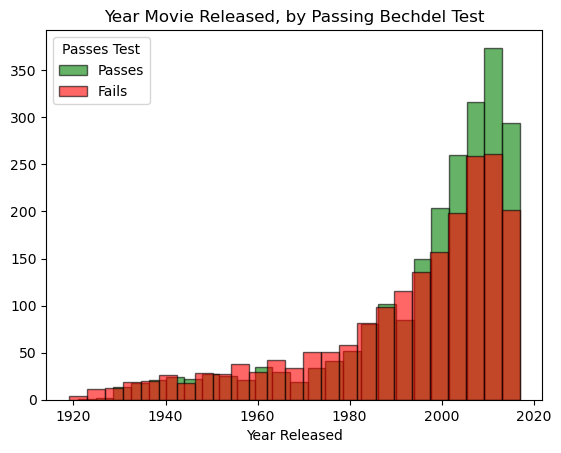

In [ ]:
## Year Released Histogram--I think this better represents the data
year_passed = movies_cast[movies_cast['passes_test'] == 'Passes']['year']
year_failed = movies_cast[movies_cast['passes_test'] == 'Fails']['year']

plt.hist(year_passed, bins = 25, edgecolor='black', label = 'Passes', alpha = 0.6, color='g')
plt.hist(year_failed, bins = 25, edgecolor='black', label = 'Fails', alpha = 0.6, color='r')

plt.legend(title='Passes Test')
plt.xlabel('Year Released')
plt.title('Year Movie Released, by Passing Bechdel Test')

Passes Stats
original_language
en    2052
fr      88
de      37
ja      28
es      27
it      17
Name: count, dtype: int64
Fails Stats
original_language
en    1848
fr      56
ja      23
de      21
es      17
it      11
Name: count, dtype: int64


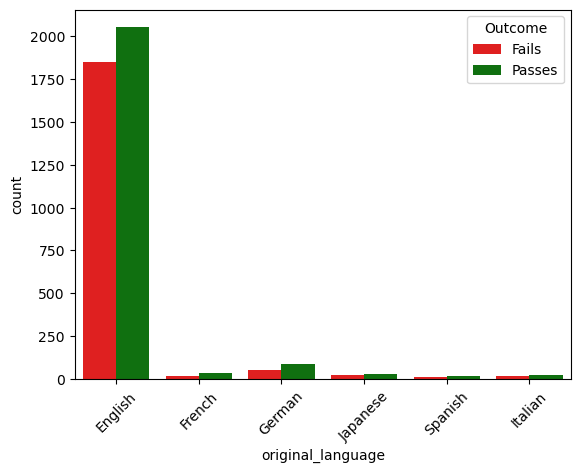

In [405]:
# Crew Language
    # Overwhelmingly English...not surprised
print('Passes Stats')
print(movies_cast[movies_cast['passes_test'] == 'Passes']['original_language'].value_counts())
print('Fails Stats')
print(movies_cast[movies_cast['passes_test'] == 'Fails']['original_language'].value_counts())

cast_lang = sns.countplot(data=movies_cast, x='original_language', hue='passes_test', palette=['r', 'g'])
plt.legend(title='Outcome')
cast_lang.set_xticklabels(lang_labels)
plt.xticks(rotation=45)
plt.show()

Crew Genre Counts
           Pass  Fail
genre                
Action      346   576
Adventure   315   416
Animation   118   107
Comedy      849   651
Crime       217   369
Drama      1121   961
Family      245   163
Fantasy     239   177
Foreign       4     3
History      62    99
Horror      382   178
Music       109    68
Mystery     198   159
Romance     517   303
TV Movie     13     5
Thriller    536   591
War          38    87
Western      20    64


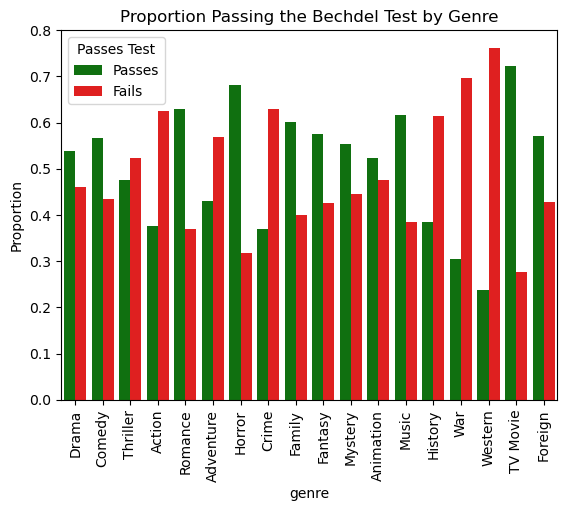

In [ ]:
# Crew Genre Counts
    # If we're including original language, we might want to omit foreign films as a predictor...
print('Crew Genre Counts')
# print((movies_cast[genres] == 1).sum())

melted = movies_cast.melt(
    id_vars=['year', 'title', 'imdb_id', 'id', 'rating', 'runtime', 'release_date',
       'original_language', 'avg_cast_gender', 'directing_avg_gender',
       'production_avg_gender', 'writing_avg_gender', 'original_title',
       'passes_test'], # columns to keep as is
    value_vars=genres, # genres to melt
    var_name='genre',
    value_name='has_genre'
)
melted = melted[melted['has_genre'] == 1]
counts = melted.groupby(['genre', 'passes_test']).size().reset_index(name='count')
counts = counts.sort_values('count', ascending=False)
totals = counts.groupby('genre')['count'].transform('sum')
counts['proportion'] = counts['count'] / totals

value_counts = melted.groupby(['genre', 'passes_test']).size().unstack(fill_value=0)
value_counts.columns = ['Fail', 'Pass']
value_counts = value_counts.iloc[:, ::-1]
print(value_counts)

# Plot
sns.barplot(data=counts, x='genre', y='proportion', hue='passes_test', palette=['g', 'r'])
plt.title('Movie Proportions Passing the Bechdel Test by Genre')
plt.ylabel('Proportion')
plt.legend(title='Passes Test')
plt.xticks(rotation=90)
plt.show()
# Because legend colours got screwy
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor='g', label='Passes'),
                   Patch(facecolor='r', label='Fails')]

# # Sanity Check
# print('Passes (Drama)')
# print(movies_cast[movies_cast['passes_test'] == 'Passes']['Drama'].value_counts())
# print('Fails (Drama)')
# print(movies_cast[movies_cast['passes_test'] == 'Fails']['Drama'].value_counts())

Gender Split Within Passing Test
       avg_cast_gender  directing_avg_gender  production_avg_gender  \
count      2249.000000           2249.000000            2249.000000   
mean          0.584019              0.831125               0.710855   
std           0.171091              0.330722               0.292097   
min           0.000000              0.000000               0.000000   
25%           0.500000              1.000000               0.500000   
50%           0.600000              1.000000               0.750000   
75%           0.703704              1.000000               1.000000   
max           1.000000              1.000000               1.000000   

       writing_avg_gender  
count         2249.000000  
mean             0.824737  
std              0.343628  
min              0.000000  
25%              1.000000  
50%              1.000000  
75%              1.000000  
max              1.000000  
Gender Split Within Failing Test
       avg_cast_gender  directing_avg_gend

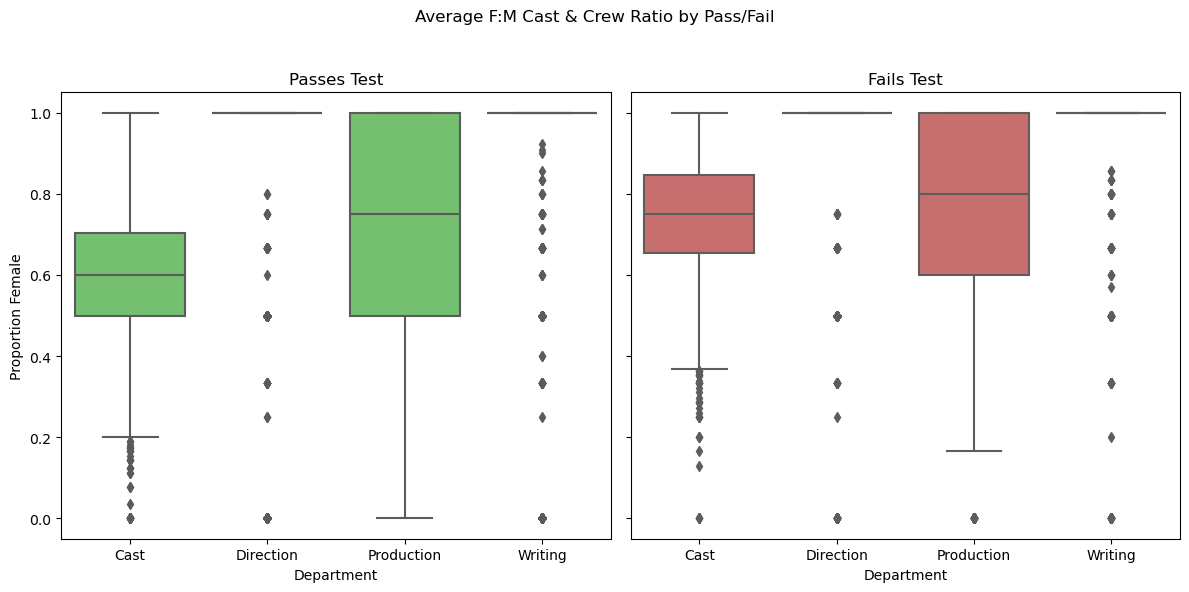

In [423]:
## Crew Analysis
# Pretty female-heavy in all but the cast department (a little female-heavy, but more of an even split)
print('Gender Split Within Passing Test')
print(movies_cast[movies_cast['passes_test'] == 'Passes'][gender_splits].describe())
print('Gender Split Within Failing Test')
print(movies_cast[movies_cast['passes_test'] == 'Fails'][gender_splits].describe())

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot for passing
sns.boxplot(data=movies_cast[gender_splits][movies_cast['passes_test'] == 'Passes'],
            color=sns.color_palette("muted")[2], ax=axes[0])
axes[0].set_title('Passes Test')
axes[0].set_xticklabels(department_labels)
axes[0].set_ylabel('Proportion Female')
axes[0].set_xlabel('Department')

# Plot for failing
sns.boxplot(data=movies_cast[gender_splits][movies_cast['passes_test'] == 'Fails'],
            color=sns.color_palette("muted")[3], ax=axes[1])
axes[1].set_title('Fails Test')
axes[1].set_xticklabels(department_labels)
axes[1].set_xlabel('Department')

plt.suptitle('Average F:M Cast & Crew Ratio by Pass/Fail')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# This split was...unexpected to say the least
    # Looks like there's not much of a difference in the writing/directing departments given their already large proportions,
    # but there is a HIGHER ratio of female cast members and producers when the movie fails the Bechdel test